In [24]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, jacfwd, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.lax import scan
from scipy.linalg import solve_discrete_are, norm
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum, plot_optimization_results
from jax_filters import apply_filtering_fixed_nonlinear, kalman_filter_process, filter_step_nonlinear, ensrf_steps, kalman_filter_process
from jax_models import visualize_observations, Lorenz63, KuramotoSivashinsky, generate_true_states, generate_localization_matrix

# Parameters
F = 8.0
dt = 0.01
num_steps = 250  # Number of time steps

J0 = 0
n = 3  # Number of state variables
Q = 0.2 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
H = jnp.eye(n)  # Observation matrix

N = 10 # number of MC samples
n_ensemble = 30
observation_interval = 1
initial_state = random.normal(random.PRNGKey(0), (n,))  # Initial state
m0 = initial_state
C0 = Q

l63_model = Lorenz63(dt = dt)
l63_step = Partial(l63_model.step)
state_transition_function = l63_step

jacobian_function = jacrev(l63_step, argnums=0)
jac_func = Partial(jacobian_function)
# Generate true states and observations using the Lorenz '63 model
key = random.PRNGKey(0)
observations, true_states = generate_true_states(key, num_steps, n, initial_state, H, Q, R, l63_step, observation_interval)

In [25]:
# plt.pcolormesh(c[-1])
# plt.colorbar()

In [26]:
from jax_vi import KL_gaussian, log_likelihood, KL_sum

def var_cost(inflation, ensemble_init, observations, H, Q, R, localization_matrix, key, num_steps, J0):
    pred_states, pred_covar, states, covariances = ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    pred_mean = jnp.mean(pred_states, axis = -1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(pred_mean, pred_covar, ensemble_mean, covariances, n, state_transition_function, Q, key)

    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, num_steps, J0)  
    cost = kl_sum - jnp.nanmean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    
    return cost

In [27]:
base_m, base_C, base_K  = kalman_filter_process(state_transition_function, jac_func, m0, C0, observations, H, Q, R)


In [28]:
from IPython.display import clear_output
from jax import grad
from tqdm.notebook import tqdm
import jax.numpy as jnp
from jax import random
import properscoring

var_cost_grad = grad(var_cost, argnums=0)

inflation_opt = 1.45 # Example starting value for inflation
radius = 3
alpha = 1e-5  # Learning rate
key = random.PRNGKey(0)  # Random key
N = 20  # Number of MC samples
m0 = initial_state
C0 = Q  # Initial covariance, assuming Q is your process noise covariance
# localization_matrix = generate_localization_matrix(n, radius) 
localization_matrix = jnp.ones((n,n)) # no localization
ensemble_init = random.multivariate_normal(key, initial_state, Q, (n_ensemble,)).T

crpss = []
rmses=[]
inflations = []
true_div = []
covars = []
analysis_states = []

n_iters = 200


for i in tqdm(range(n_iters)):
    key, subkey = random.split(key)
        
    # Gradient descent step for inflation parameter
    grad_inflation = var_cost_grad(inflation_opt, ensemble_init, observations, H, Q, R, localization_matrix, subkey, num_steps, J0)
    inflation_opt -= alpha * grad_inflation  # Update inflation parameter
    inflations.append(inflation_opt)

    pred_states, pred_covariances, states, covariances = ensrf_steps(state_transition_function, n_ensemble, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation_opt, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    rmse = jnp.sqrt(jnp.mean((ensemble_mean - true_states)**2))
    rmses.append(rmse)
    crps = properscoring.crps_ensemble(true_states, states).mean(axis=1).mean()
    crpss.append(crps)
    total_kl_divergence = 0
    for t in range(num_steps):  
        kl_div_t = KL_gaussian(n, ensemble_mean[t], covariances[t],  base_m[t], base_C[t])
        total_kl_divergence += kl_div_t
    true_div.append(total_kl_divergence / num_steps)
    covars.append(covariances)
    analysis_states.append(states)




  0%|          | 0/200 [00:00<?, ?it/s]

In [35]:
import pickle
result_dict = {'crpss': crpss, 'rmses': rmses, 'covars': covars, 'inflations': inflations, 'true_div': true_div, 'analysis_states': analysis_states}
with open('simulation_results.pkl', 'wb') as f:
    pickle.dump(result_dict, f)

In [36]:
from jax_filters import particle_filter
# import jax_filters
# import importlib
# importlib.reload(jax_filters)
num_particles = 2000
estimated_states = particle_filter(key, num_particles, num_steps, initial_state, observations, observation_interval, state_transition_function, H, Q, R)


In [37]:
part_mean = jnp.mean(estimated_states, axis=-1)  # Taking the mean across the ensemble members dimension
part_rmse = jnp.sqrt(jnp.mean((part_mean - true_states)**2))
print(f"Particle Filter RMSE: {part_rmse}")
print(f"Tuned ENSRF RMSE: {rmses[-1]}")


Particle Filter RMSE: 0.4903407692909241
Tuned ENSRF RMSE: 0.5104638338088989


In [38]:
part_mean = jnp.mean(estimated_states, axis=-1)  # Taking the mean across the ensemble members dimension
part_rmse = jnp.sqrt(jnp.mean((part_mean - true_states)**2))
print(f"Particle Filter RMSE: {part_rmse}")

Particle Filter RMSE: 0.4903407692909241


In [39]:
covars[0].shape
def calculate_covariance_matrix(states):
    mean = jnp.mean(states, axis=2)
    deviations = states - mean[:, :, jnp.newaxis]
    covariance_matrix = jnp.einsum('ijk,ilk->ijl', deviations, deviations) / (states.shape[2] - 1)
    return covariance_matrix
particle_covars = calculate_covariance_matrix(estimated_states)

In [40]:
covar_diffs = []
for iter_covars in covars:
    frobenius_norms = jnp.array([jnp.linalg.norm(particle_covars[i] - iter_covars[i], 'fro') for i in range(num_steps)])
    covar_diffs.append(jnp.mean(frobenius_norms))


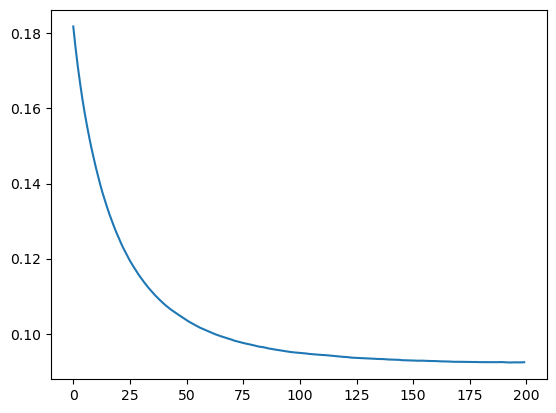

In [41]:
plt.plot(covar_diffs)

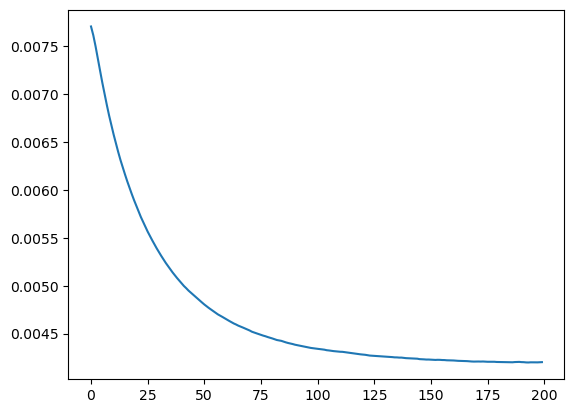

In [42]:
part_mean = jnp.mean(estimated_states, axis=-1)  # Taking the mean across the ensemble members dimension
mean_diffs = []
for analy in analysis_states:
    analy_mean =  jnp.mean(analy, axis=-1) 
    mean_diffs.append(jnp.mean(analy_mean - part_mean))
plt.plot(mean_diffs)

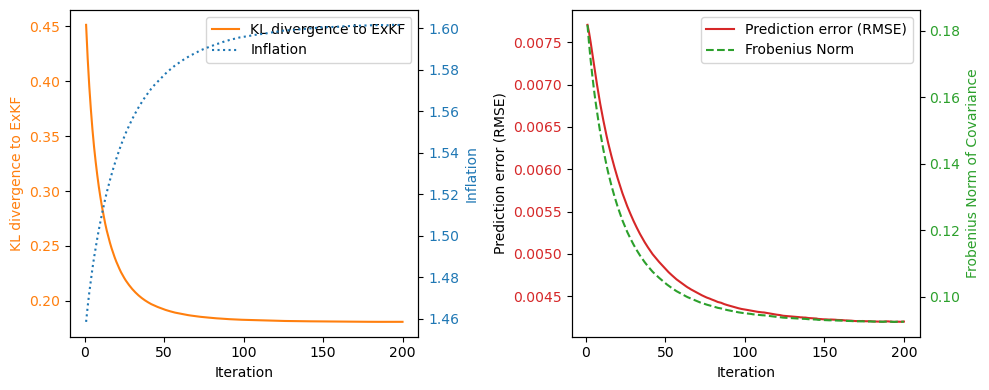

In [43]:
fig, (ax1, ax3) = plt.subplots(figsize=(10, 4), ncols=2)

color = 'tab:orange'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('KL divergence to ExKF', color=color)
ln1 = ax1.plot(range(1, n_iters+1), true_div, label='KL divergence to ExKF', color=color, linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Inflation', color=color)
ln3 = ax2.plot(range(1, n_iters+1), inflations, label='Inflation', color=color, linestyle=':')
ax2.tick_params(axis='y', labelcolor=color)

lns = ln1 + ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='upper right')

ax3.plot(range(1, n_iters+1), mean_diffs, label='Me', color='tab:red')
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Prediction error (RMSE)")
ax3.tick_params(axis='y', labelcolor='tab:red')

ax4 = ax3.twinx()
color = 'tab:green'
ax4.set_ylabel('Frobenius Norm of Covariance (EnSRF vs Fixed Particle Filter))', color=color)
ln4 = ax4.plot(range(1, n_iters+1), covar_diffs, label='Frobenius Norm', color=color, linestyle='--')
ax4.tick_params(axis='y', labelcolor=color)

# Combine legends from ax3 and ax4
lns2 = ax3.get_lines() + ax4.get_lines()
labs2 = [l.get_label() for l in lns2]
ax3.legend(lns2, labs2, loc='upper right')

plt.tight_layout()

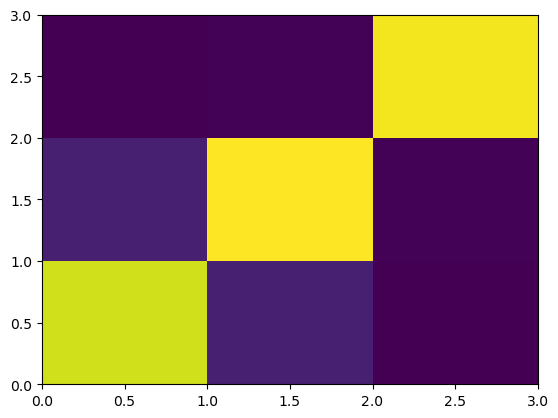

In [35]:
plt.pcolormesh(base_C[-1, :, :])

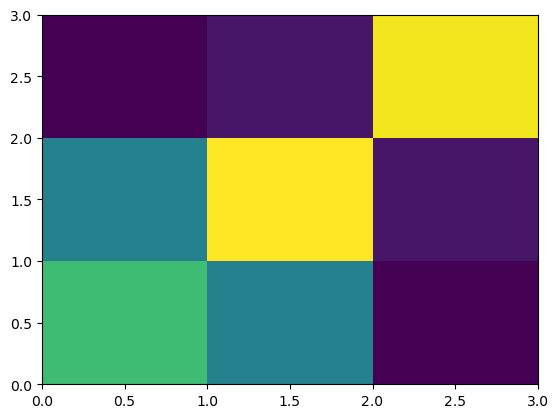

In [36]:
plt.pcolormesh(covariances[-1])